# OSMnx Street Network Analysis

In [1]:
%matplotlib inline

In [5]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd

for module in [pd, gpd, mpl, ox]:
    print(module.__name__, module.__version__)

pandas 1.4.1
geopandas 0.10.2
matplotlib 3.3.2
osmnx 1.1.2


# Load Region

Uses the region from [Nominatim](https://nominatim.openstreetmap.org/).

In [7]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    G = ox.graph_from_place('Anif', simplify=True)

CPU times: user 3.31 s, sys: 31.3 ms, total: 3.35 s
Wall time: 3.35 s


In [8]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [9]:
%%time
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

CPU times: user 293 ms, sys: 4.02 ms, total: 297 ms
Wall time: 299 ms


In [10]:
print(f"Num nodes: {len(nodes)}, num edges: {len(edges)}")

Num nodes: 1052, num edges: 2644


In [11]:
nodes.head(2)

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
35608985,47.736797,13.050801,3,NaN,NaN,POINT (13.05080 47.73680)
35608995,47.747770,13.066764,4,traffic_signals,NaN,POINT (13.06676 47.74777)


In [12]:
edges.head(2)

osmid lanes   ref                    name  \
u        v          key                                                  
35608985 4475973575 0    244159321     4  B160  Berchtesgadener Straße   
         7001083238 0    748619266   NaN   NaN                     NaN   

                         highway maxspeed  oneway  length        service  \
u        v          key                                                    
35608985 4475973575 0    primary       50   False  12.319            NaN   
         7001083238 0    service      NaN   False   8.725  parking_aisle   

                                                                  geometry  \
u        v          key                                                      
35608985 4475973575 0    LINESTRING (13.05080 47.73680, 13.05073 47.73670)   
         7001083238 0    LINESTRING (13.05080 47.73680, 13.05070 47.73684)   

                        bridge access width junction tunnel  
u        v          key                                      
35608985 4475973575 0      NaN    NaN   NaN      NaN    NaN  
         7001083238 0      NaN    NaN   NaN      NaN    NaN

In [13]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Project Data

In [14]:
%%time
G_projected = ox.project_graph(G)

CPU times: user 686 ms, sys: 7.68 ms, total: 694 ms
Wall time: 693 ms


In [15]:
%%time
nodes_proj, edges_proj = ox.graph_to_gdfs(
    G_projected, nodes=True, edges=True)

CPU times: user 163 ms, sys: 127 µs, total: 163 ms
Wall time: 163 ms


In [16]:
edges_proj.crs

<Derived Projected CRS: +proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

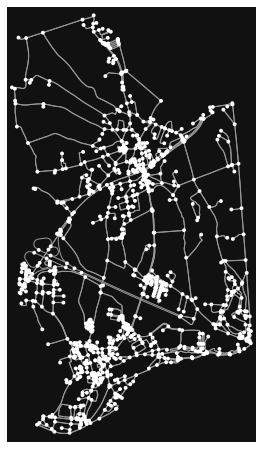

In [17]:
fig, ax = ox.plot_graph(G_projected)

# Calculate Basic Stats

In [18]:
%%time
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
# Show output
convex_hull

# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(G_projected, area=area)
stats

CPU times: user 10.5 s, sys: 175 ms, total: 10.7 s
Wall time: 10.7 s


{'n': 1052,
 'm': 2644,
 'k_avg': 5.026615969581749,
 'edge_length_total': 190890.99900000036,
 'edge_length_avg': 72.19780597579438,
 'streets_per_node_avg': 2.656844106463878,
 'streets_per_node_counts': {0: 0, 1: 230, 2: 8, 3: 709, 4: 103, 5: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.21863117870722434,
  2: 0.0076045627376425855,
  3: 0.6739543726235742,
  4: 0.0979087452471483,
  5: 0.0019011406844106464},
 'intersection_count': 822,
 'street_length_total': 100403.31600000011,
 'street_segment_count': 1378,
 'street_length_avg': 72.86162264150951,
 'circuity_avg': 1.0756563373215995,
 'self_loop_proportion': 0.00362844702467344,
 'node_density_km': 127.3545925250916,
 'intersection_density_km': 99.51090784755257,
 'edge_density_km': 23109.168625810566,
 'street_density_km': 12154.775092536145}

# Calculate Extended Statistics

In [21]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    extended_stats = ox.extended_stats(G_projected, ecc=True, cc=True)

series = pd.Series(extended_stats)
series

CPU times: user 10.5 s, sys: 11.6 ms, total: 10.5 s
Wall time: 10.5 s


avg_neighbor_degree                    {35608985: 3.3333333333333335, 4475973575: 3.3...
avg_neighbor_degree_avg                                                         2.829024
avg_weighted_neighbor_degree           {35608985: 0.12612408087076066, 4475973575: 0....
avg_weighted_neighbor_degree_avg                                                0.081831
degree_centrality                      {35608985: 0.005708848715509039, 4475973575: 0...
degree_centrality_avg                                                           0.004783
clustering_coefficient                 {35608985: 0, 4475973575: 0, 7001083238: 0, 28...
clustering_coefficient_avg                                                      0.048828
clustering_coefficient_weighted        {35608985: 0, 4475973575: 0, 7001083238: 0, 28...
clustering_coefficient_weighted_avg                                             0.001839
pagerank                               {35608985: 0.0009161455712058846, 4475973575: ...
pagerank_max_node    

# Visualizing Statistics

- [Urban Street Network Centrality](https://geoffboeing.com/2018/01/urban-street-network-centrality/)

In [22]:
stats_columns = [
    'avg_neighbor_degree', 
    'degree_centrality', 
    'clustering_coefficient', 
    'pagerank', 
    'eccentricity', 
    'closeness_centrality'
]

series_list = [pd.Series(extended_stats[column_name], name=column_name).sort_index()
               for column_name in stats_columns]
series_list.append(nodes_proj['geometry'].sort_index())

gdf_stats = pd.concat(series_list, axis=1)

gdf_stats = gpd.GeoDataFrame(
    gdf_stats, geometry="geometry", crs=nodes_proj.crs)
gdf_stats.head(2)

,avg_neighbor_degree,degree_centrality,clustering_coefficient,pagerank,eccentricity,closeness_centrality,geometry
35608985,3.333333,0.005709,0.0,0.000916,3675.525,0.000536,POINT (353863.155 5288886.910)
35608995,3.500000,0.007612,0.0,0.000948,3277.142,0.000638,POINT (355090.323 5290076.386)


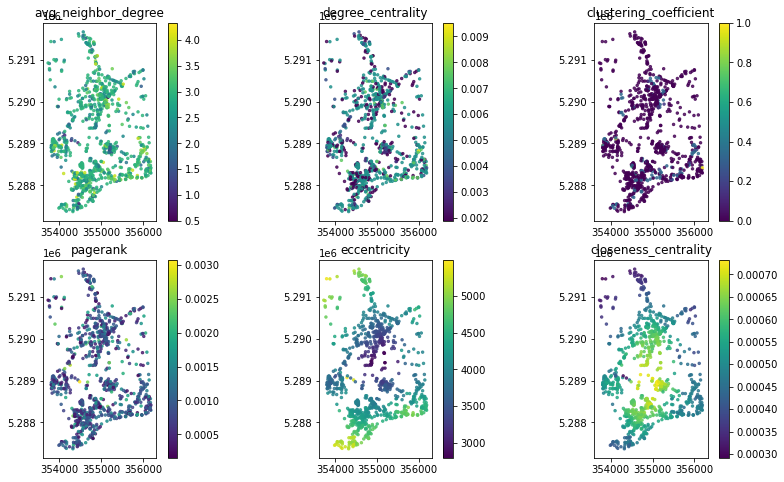

In [23]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))

for idx, column_name in enumerate(stats_columns):
    j = idx % ncols
    i = (idx - j) // ncols
    
    ax = axes[i][j]
    gdf_stats.plot(ax=ax, column=column_name, legend=True, s=6, alpha=0.8)
    ax.set_title(column_name)

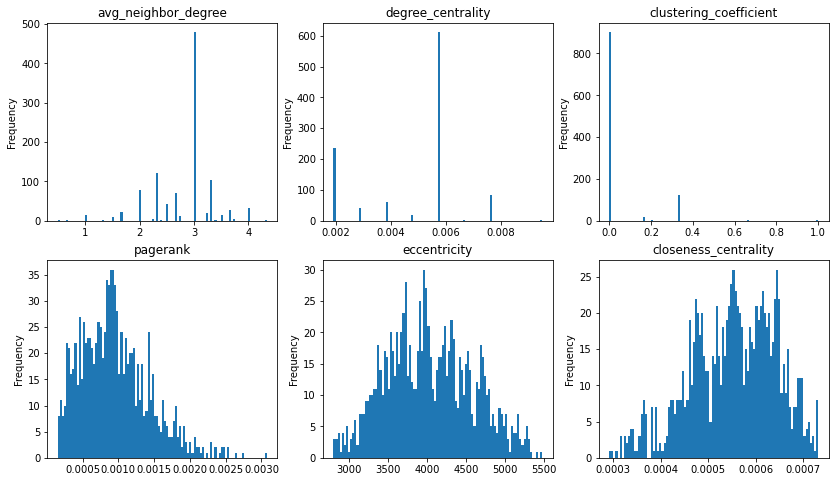

In [24]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))

for idx, column_name in enumerate(stats_columns):
    j = idx % ncols
    i = (idx - j) // ncols
    
    ax = axes[i][j]
    gdf_stats[column_name].plot(ax=ax, kind='hist', bins=100)
    ax.set_title(column_name)

# Further Resources

- [Automating GIS-processes - Lesson 6](https://automating-gis-processes.github.io/site/lessons/L6/overview.html)
    - [Network analysis in Python](https://automating-gis-processes.github.io/site/notebooks/L6/network-analysis.html)
- [OSMnx overview: querying, simplifying, visualizing, saving](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/01-overview-osmnx.ipynb)
- [OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks](https://geoffboeing.com/publications/osmnx-complex-street-networks/)
- [OSMnx: Python for Street Networks](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
- [Urban Street Network Centrality](https://geoffboeing.com/2018/01/urban-street-network-centrality/)